In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_075_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_075_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_17 (Activation)   (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_38 (Activation)   (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3504 - acc: 0.2346
Epoch 00001: val_loss improved from inf to 1.91396, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_3_conv_checkpoint/001-1.9140.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.3503 - acc: 0.2346 - val_loss: 1.9140 - val_acc: 0.3755
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6911 - acc: 0.4539
Epoch 00002: val_loss improved from 1.91396 to 1.61010, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_3_conv_checkpoint/002-1.6101.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.6913 - acc: 0.4538 - val_loss: 1.6101 - val_acc: 0.4861
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3588 - acc: 0.5631
Epoch 00003: val_loss improved from 1.61010 to 1.54886, savin

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2624 - acc: 0.9171
Epoch 00028: val_loss did not improve from 1.08680
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2623 - acc: 0.9172 - val_loss: 1.3152 - val_acc: 0.7126
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2645 - acc: 0.9148
Epoch 00029: val_loss did not improve from 1.08680
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2645 - acc: 0.9148 - val_loss: 1.4070 - val_acc: 0.6799
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2554 - acc: 0.9198
Epoch 00030: val_loss did not improve from 1.08680
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2554 - acc: 0.9198 - val_loss: 1.3925 - val_acc: 0.7046
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2506 - acc: 0.9205
Epoch 00031: val_loss did not improve from 1.08680
36805/36805 [===========


1D_CNN_custom_DO_075_DO_SGD_3_conv Model


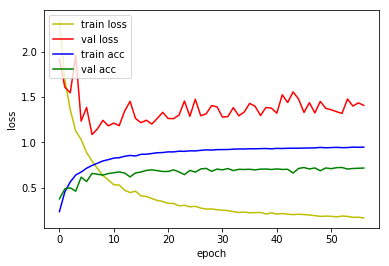

4815/4815 [==============================] - 3s 546us/sample - loss: 1.2394 - acc: 0.6226
Loss: 1.2393806066592288 Accuracy: 0.62263757

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2346 - acc: 0.2645
Epoch 00001: val_loss improved from inf to 1.95412, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_4_conv_checkpoint/001-1.9541.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.2347 - acc: 0.2645 - val_loss: 1.9541 - val_acc: 0.3664
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5335 - acc: 0.5019
Epoch 00002: val_loss improved from 1.95412 to 1.14279, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_4_conv_checkpoint/002-1.1428.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.5334 - acc: 0.5019 - val_loss: 1.1428 - val_acc: 0.6413
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.3606 - acc: 0.8802
Epoch 00027: val_loss did not improve from 0.68290
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3606 - acc: 0.8803 - val_loss: 0.7526 - val_acc: 0.8064
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3617 - acc: 0.8827
Epoch 00028: val_loss did not improve from 0.68290
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3617 - acc: 0.8827 - val_loss: 0.7817 - val_acc: 0.7957
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3478 - acc: 0.8834
Epoch 00029: val_loss did not improve from 0.68290
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3478 - acc: 0.8834 - val_loss: 0.8407 - val_acc: 0.7838
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3496 - acc: 0.8854
Epoch 00030: val_loss did not improve from 0.68290
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2767 - acc: 0.9091
Epoch 00057: val_loss did not improve from 0.68290
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2767 - acc: 0.9091 - val_loss: 0.8211 - val_acc: 0.8178
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2668 - acc: 0.9129
Epoch 00058: val_loss did not improve from 0.68290
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2668 - acc: 0.9129 - val_loss: 0.7740 - val_acc: 0.8123
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2607 - acc: 0.9140
Epoch 00059: val_loss did not improve from 0.68290
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2606 - acc: 0.9140 - val_loss: 0.8056 - val_acc: 0.8083
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2636 - acc: 0.9126
Epoch 00060: val_loss did not improve from 0.68290
36805/36805 [===========

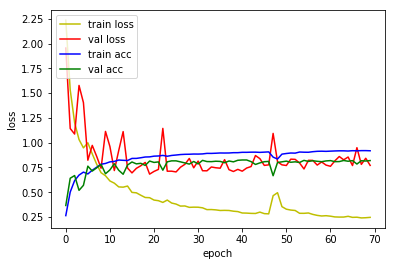

4815/4815 [==============================] - 3s 571us/sample - loss: 0.8214 - acc: 0.7726
Loss: 0.82138472635798 Accuracy: 0.7725857

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1963 - acc: 0.2748
Epoch 00001: val_loss improved from inf to 2.06665, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_5_conv_checkpoint/001-2.0667.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.1962 - acc: 0.2749 - val_loss: 2.0667 - val_acc: 0.3464
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5179 - acc: 0.5092
Epoch 00002: val_loss improved from 2.06665 to 1.10882, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_5_conv_checkpoint/002-1.1088.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.5179 - acc: 0.5092 - val_loss: 1.1088 - val_acc: 0.6469
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3205 - acc: 0.8962
Epoch 00027: val_loss did not improve from 0.48599
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3204 - acc: 0.8962 - val_loss: 0.5311 - val_acc: 0.8654
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3127 - acc: 0.8983
Epoch 00028: val_loss did not improve from 0.48599
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3126 - acc: 0.8983 - val_loss: 0.5165 - val_acc: 0.8616
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2973 - acc: 0.9016
Epoch 00029: val_loss did not improve from 0.48599
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2973 - acc: 0.9016 - val_loss: 0.5217 - val_acc: 0.8735
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3008 - acc: 0.9021
Epoch 00030: val_loss did not improve from 0.48599
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2128 - acc: 0.9307
Epoch 00057: val_loss did not improve from 0.48599
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2127 - acc: 0.9307 - val_loss: 0.5346 - val_acc: 0.8763
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2037 - acc: 0.9333
Epoch 00058: val_loss did not improve from 0.48599
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2038 - acc: 0.9332 - val_loss: 0.5545 - val_acc: 0.8826
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2080 - acc: 0.9330
Epoch 00059: val_loss did not improve from 0.48599
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2080 - acc: 0.9331 - val_loss: 0.5577 - val_acc: 0.8761
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2007 - acc: 0.9347
Epoch 00060: val_loss did not improve from 0.48599
36805/36805 [===========

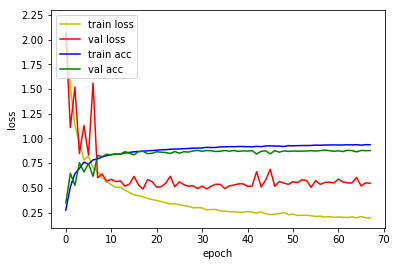

4815/4815 [==============================] - 3s 580us/sample - loss: 0.5893 - acc: 0.8351
Loss: 0.5893327088742242 Accuracy: 0.8350986

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3990 - acc: 0.2105
Epoch 00001: val_loss improved from inf to 1.86501, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_6_conv_checkpoint/001-1.8650.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.3989 - acc: 0.2106 - val_loss: 1.8650 - val_acc: 0.4128
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6784 - acc: 0.4402
Epoch 00002: val_loss improved from 1.86501 to 1.37932, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_6_conv_checkpoint/002-1.3793.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.6784 - acc: 0.4402 - val_loss: 1.3793 - val_acc: 0.5514
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2738 - acc: 0.9133
Epoch 00026: val_loss did not improve from 0.30270
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2738 - acc: 0.9133 - val_loss: 0.3170 - val_acc: 0.9201
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2532 - acc: 0.9204
Epoch 00027: val_loss did not improve from 0.30270
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2532 - acc: 0.9204 - val_loss: 0.3574 - val_acc: 0.9038
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2539 - acc: 0.9195
Epoch 00028: val_loss did not improve from 0.30270
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2539 - acc: 0.9195 - val_loss: 0.3219 - val_acc: 0.9094
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2442 - acc: 0.9217
Epoch 00029: val_loss did not improve from 0.30270
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1644 - acc: 0.9463
Epoch 00055: val_loss improved from 0.28330 to 0.28188, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_6_conv_checkpoint/055-0.2819.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1644 - acc: 0.9463 - val_loss: 0.2819 - val_acc: 0.9320
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1595 - acc: 0.9481
Epoch 00056: val_loss did not improve from 0.28188
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1595 - acc: 0.9481 - val_loss: 0.3176 - val_acc: 0.9292
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1677 - acc: 0.9456
Epoch 00057: val_loss did not improve from 0.28188
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1677 - acc: 0.9456 - val_loss: 0.3065 - val_acc: 0.9301
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1604 - 

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1315 - acc: 0.9574
Epoch 00085: val_loss did not improve from 0.28188
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1315 - acc: 0.9574 - val_loss: 0.3235 - val_acc: 0.9366
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1343 - acc: 0.9579
Epoch 00086: val_loss did not improve from 0.28188
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1343 - acc: 0.9579 - val_loss: 0.3546 - val_acc: 0.9208
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1434 - acc: 0.9538
Epoch 00087: val_loss did not improve from 0.28188
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1434 - acc: 0.9538 - val_loss: 0.3223 - val_acc: 0.9283
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1323 - acc: 0.9563
Epoch 00088: val_loss did not improve from 0.28188
36805/36805 [===========

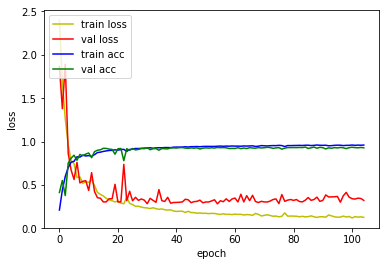

4815/4815 [==============================] - 3s 621us/sample - loss: 0.3347 - acc: 0.9140
Loss: 0.3347402188513014 Accuracy: 0.9140187

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5201 - acc: 0.1661
Epoch 00001: val_loss improved from inf to 2.25108, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_7_conv_checkpoint/001-2.2511.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.5201 - acc: 0.1661 - val_loss: 2.2511 - val_acc: 0.3007
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7287 - acc: 0.4235
Epoch 00002: val_loss improved from 2.25108 to 1.41802, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_7_conv_checkpoint/002-1.4180.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.7287 - acc: 0.4236 - val_loss: 1.4180 - val_acc: 0.5330
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1898 - acc: 0.9392
Epoch 00026: val_loss did not improve from 0.17746
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1899 - acc: 0.9391 - val_loss: 0.1841 - val_acc: 0.9529
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1848 - acc: 0.9421
Epoch 00027: val_loss did not improve from 0.17746
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1849 - acc: 0.9421 - val_loss: 0.2074 - val_acc: 0.9420
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1862 - acc: 0.9398
Epoch 00028: val_loss did not improve from 0.17746
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1862 - acc: 0.9398 - val_loss: 0.1934 - val_acc: 0.9478
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1789 - acc: 0.9426
Epoch 00029: val_loss did not improve from 0.17746
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1105 - acc: 0.9642
Epoch 00055: val_loss did not improve from 0.17098
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1104 - acc: 0.9642 - val_loss: 0.1909 - val_acc: 0.9483
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1146 - acc: 0.9634
Epoch 00056: val_loss did not improve from 0.17098
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1146 - acc: 0.9634 - val_loss: 0.1939 - val_acc: 0.9490
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1067 - acc: 0.9652
Epoch 00057: val_loss did not improve from 0.17098
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1067 - acc: 0.9652 - val_loss: 0.2170 - val_acc: 0.9469
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1076 - acc: 0.9645
Epoch 00058: val_loss did not improve from 0.17098
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0917 - acc: 0.9701
Epoch 00085: val_loss did not improve from 0.17098
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0917 - acc: 0.9701 - val_loss: 0.2515 - val_acc: 0.9448
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0863 - acc: 0.9718
Epoch 00086: val_loss did not improve from 0.17098
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0863 - acc: 0.9718 - val_loss: 0.2109 - val_acc: 0.9569
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0867 - acc: 0.9722
Epoch 00087: val_loss did not improve from 0.17098
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0867 - acc: 0.9722 - val_loss: 0.2171 - val_acc: 0.9539

1D_CNN_custom_DO_075_DO_SGD_7_conv Model


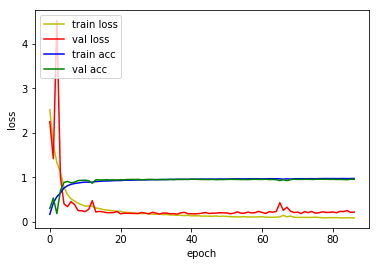

4815/4815 [==============================] - 3s 635us/sample - loss: 0.2094 - acc: 0.9431
Loss: 0.20942693221482409 Accuracy: 0.9430945

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5522 - acc: 0.1508
Epoch 00001: val_loss improved from inf to 2.03012, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_8_conv_checkpoint/001-2.0301.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.5522 - acc: 0.1508 - val_loss: 2.0301 - val_acc: 0.3454
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5673 - acc: 0.4753
Epoch 00002: val_loss improved from 2.03012 to 1.03297, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_8_conv_checkpoint/002-1.0330.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.5673 - acc: 0.4753 - val_loss: 1.0330 - val_acc: 0.6751
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1203 - acc: 0.9619
Epoch 00025: val_loss did not improve from 0.11564
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1203 - acc: 0.9619 - val_loss: 0.1457 - val_acc: 0.9611
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1214 - acc: 0.9614
Epoch 00026: val_loss did not improve from 0.11564
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1215 - acc: 0.9614 - val_loss: 0.1517 - val_acc: 0.9611
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1176 - acc: 0.9621
Epoch 00027: val_loss did not improve from 0.11564
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1176 - acc: 0.9621 - val_loss: 0.1340 - val_acc: 0.9641
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1056 - acc: 0.9661
Epoch 00028: val_loss did not improve from 0.11564
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0654 - acc: 0.9793
Epoch 00055: val_loss did not improve from 0.11564
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0654 - acc: 0.9793 - val_loss: 0.1773 - val_acc: 0.9583
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0768 - acc: 0.9765
Epoch 00056: val_loss did not improve from 0.11564
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0767 - acc: 0.9766 - val_loss: 0.1827 - val_acc: 0.9618
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9801
Epoch 00057: val_loss did not improve from 0.11564
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0636 - acc: 0.9801 - val_loss: 0.1780 - val_acc: 0.9648
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0700 - acc: 0.9783
Epoch 00058: val_loss did not improve from 0.11564
36805/36805 [===========

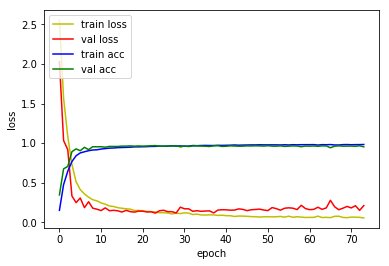

4815/4815 [==============================] - 3s 646us/sample - loss: 0.1795 - acc: 0.9510
Loss: 0.17948721637436782 Accuracy: 0.9509865

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4887 - acc: 0.1722
Epoch 00001: val_loss improved from inf to 1.89354, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_9_conv_checkpoint/001-1.8935.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 2.4887 - acc: 0.1722 - val_loss: 1.8935 - val_acc: 0.3997
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3573 - acc: 0.5565
Epoch 00002: val_loss improved from 1.89354 to 0.94862, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_SGD_9_conv_checkpoint/002-0.9486.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.3573 - acc: 0.5565 - val_loss: 0.9486 - val_acc: 0.6949
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0692 - acc: 0.9780
Epoch 00027: val_loss did not improve from 0.12249
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0692 - acc: 0.9780 - val_loss: 0.1553 - val_acc: 0.9658
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0666 - acc: 0.9792
Epoch 00028: val_loss did not improve from 0.12249
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0666 - acc: 0.9792 - val_loss: 0.1575 - val_acc: 0.9623
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0680 - acc: 0.9790
Epoch 00029: val_loss did not improve from 0.12249
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0680 - acc: 0.9790 - val_loss: 0.1406 - val_acc: 0.9672
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0715 - acc: 0.9779
Epoch 00030: val_loss did not improve from 0.12249
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0529 - acc: 0.9842
Epoch 00057: val_loss did not improve from 0.12249
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0529 - acc: 0.9842 - val_loss: 0.1850 - val_acc: 0.9641
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9858
Epoch 00058: val_loss did not improve from 0.12249
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0467 - acc: 0.9858 - val_loss: 0.1891 - val_acc: 0.9648
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0511 - acc: 0.9853
Epoch 00059: val_loss did not improve from 0.12249
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0512 - acc: 0.9852 - val_loss: 0.1863 - val_acc: 0.9641
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9846
Epoch 00060: val_loss did not improve from 0.12249
36805/36805 [===========

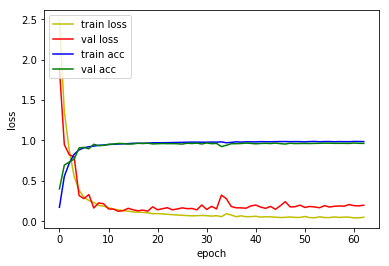

4815/4815 [==============================] - 3s 676us/sample - loss: 0.1746 - acc: 0.9479
Loss: 0.1745570547538321 Accuracy: 0.9478712



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_DO_075_DO_SGD'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_075_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
                  metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO_075_DO_SGD'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_075_DO_SGD_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_47 (Activation)   (None

4815/4815 [==============================] - 3s 665us/sample - loss: 0.3347 - acc: 0.9140
Loss: 0.3347402188513014 Accuracy: 0.9140187

1D_CNN_custom_DO_075_DO_SGD_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_63 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_64 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_65 (Conv1D)           (N

4815/4815 [==============================] - 3s 696us/sample - loss: 0.1746 - acc: 0.9479
Loss: 0.1745570547538321 Accuracy: 0.9478712


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_075_DO_SGD_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_47 (Activation)   (None

4815/4815 [==============================] - 3s 699us/sample - loss: 0.3550 - acc: 0.9124
Loss: 0.35496825700546475 Accuracy: 0.9123572

1D_CNN_custom_DO_075_DO_SGD_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_63 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_64 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_65 (Conv1D)           (

4815/4815 [==============================] - 3s 727us/sample - loss: 0.1966 - acc: 0.9599
Loss: 0.19661172342202352 Accuracy: 0.95991695
